*Quick note: make sure you have the following packages installed before using this notebook!*

In [75]:
#!pip install --upgrade astropy

In [76]:
#!pip install astropy

In [77]:
#from astropy.stats import LombScargle # for periodograms
import corner # for visualizing parameter distributions
import numpy as np # for math and data storage
import pandas as pd # for math and data storage
import matplotlib.pyplot as plt # for plot making
import radvel # for fitting RVs
from radvel.plot import orbit_plots, mcmc_plots # for visualizing RVs
from scipy import optimize # for fitting RVs

# this bit below is just to fix an issue with radvel that appears if you're using numpy versions 1.22.0 or later!
try:
    np.__config__.blas_opt_info = np.__config__.blas_ilp64_opt_info
except Exception:
    pass

## Learning to use ``radvel``

Hi! I'm Drew, your mentor for the Intro2Astro workshop. In this Python notebook, I'll be showing you how to use ``radvel`` and walking you through an example of using it with real-life data.

``radvel`` is one of the most common packages people use to fit radial velocity measurements. There are other methods, such as ``exoplanet`` (which is more in-depth but harder to use, IMO), or doing it yourself in ``emcee``, but we're using radvel here.

### Part 1: Getting Our Data

Before we do anything, we should get the actual data we want to work with. Let's work with real data from the 51 Pegasi planetary system: the first planet discovered around a main-sequence star.

[The original paper](https://www.nature.com/articles/Art1) on this system doesn't have a table of the radial velocities per time, so I went ahead and pulled all the radial velocities from some plots (although I don't have the uncertainties,so we'll have to assume they're all uniform!) Let's plot the data real quick.

In [78]:
data = pd.read_csv("51 Pegasi RVs.csv", names = ['Date (JD - 2450000)', 'RV (m/s)'])
data['RV Uncertainty (m/s)'] = 5.0 # this is just an assumption -- I can't get them from plots, sorry!
data[0:10]

,Date (JD - 2450000),RV (m/s),RV Uncertainty (m/s)
0,2.70,-38.416114,5.0
1,2.80,-44.579147,5.0
2,3.10,-45.058768,5.0
3,3.65,-17.581043,5.0
4,3.80,-10.948815,5.0
5,3.95,-3.368720,5.0
6,4.65,51.594313,5.0
7,4.80,60.596209,5.0
8,4.95,65.806635,5.0
9,5.65,47.783886,5.0


Text(0, 0.5, 'RV (m/s)')

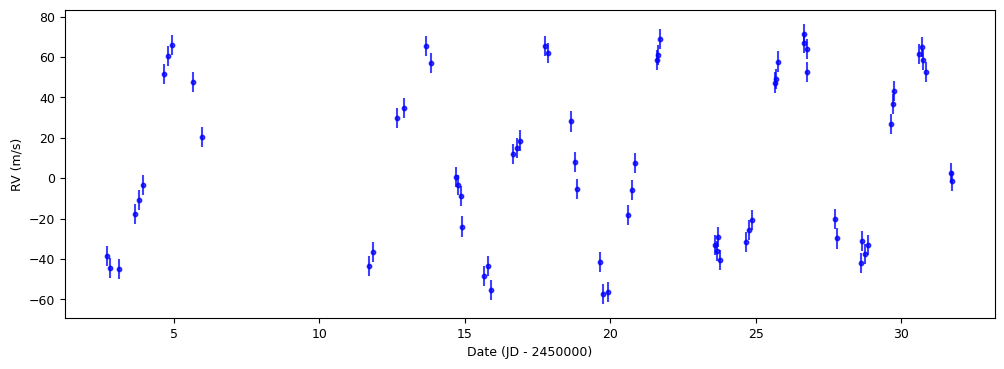

In [79]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.scatter(data['Date (JD - 2450000)'], data['RV (m/s)'], s = 10, color = 'blue', alpha = 0.75)
ax.errorbar(x = data['Date (JD - 2450000)'], y = data['RV (m/s)'], yerr = data['RV Uncertainty (m/s)'], color = 'blue', alpha = 0.75, ls = 'None')
ax.set_xlabel("Date (JD - 2450000)")
ax.set_ylabel("RV (m/s)")

### Part 2: Identifying Signals

This is what our data looks like. We have our times (in JD - 2450000, just a way of reducing a date to a small number), the radial velocities, and uniform uncertainties. We can sort of see a periodic signal, if we squint, maybe?

But we can't always see a signal with our eyes, so it's often helpful to have a computer find a periodic signal for us. To do this, we'll use a *Lomb-Scargle periodogram*. A *periodogram* is a way of using Fourier transforms to identify periodic signals in time series data like this. A *Lomb-Scargle* periodogram is a type of periodogram that works really well when you have data that is not taken at uniform spacings in time, like we have here. If you want to learn more about these periodograms, or about the math behind them, you can read [this paper](https://iopscience.iop.org/article/10.3847/1538-4365/aab766)!

But here, we're only really concerned with how they *work*. A periodogram, given data, outputs a *power* as a function of a *period*. We won't get into the math behind it, or what a *power* represents in the technical sense (since that requires understanding Fourier transforms), but a higher power represents a stronger periodic signal at that particular period. Let's calculate these powers and plot them as a function of period for our data!

In [80]:
from astropy.timeseries import LombScargle

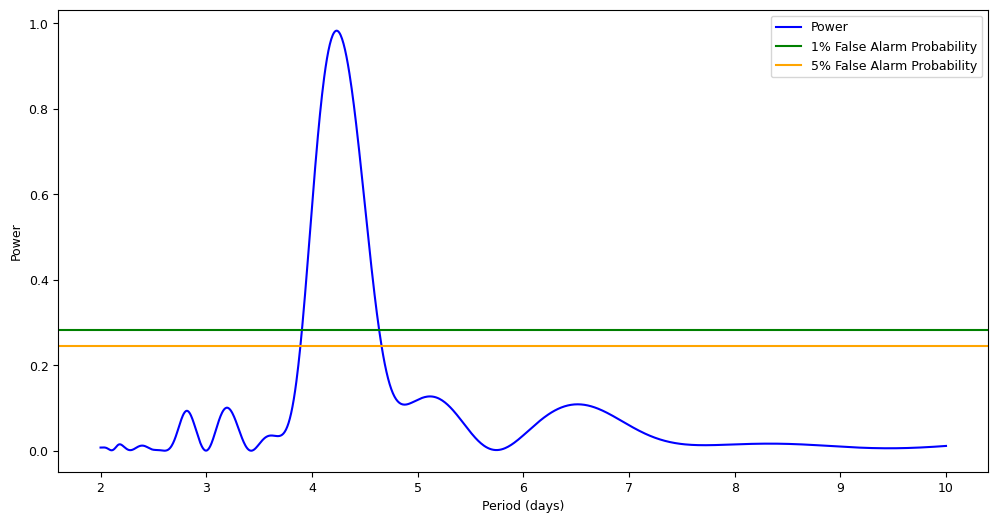

In [81]:
periods = np.logspace(np.log10(2.), np.log10(10.), num = 1000)
frequency = 1. / periods
ls = LombScargle(data['Date (JD - 2450000)'], data['RV (m/s)'], data['RV Uncertainty (m/s)'], fit_mean = True)
power = ls.power(frequency)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(periods, power, label = 'Power', c = 'blue')
ax.set_xlabel("Period (days)")
ax.set_ylabel("Power")

ax.axhline(xmin = 0, xmax = 1, y = ls.false_alarm_level([0.01]), c = 'green',  label = '1% False Alarm Probability')
ax.axhline(xmin = 0, xmax = 1, y = ls.false_alarm_level([0.05]), c = 'orange', label = '5% False Alarm Probability')

ax.legend();

I've also plotted lines of *false alarm probability*. A false alarm probability tells you "what is the odds of seeing a peak of this height (or higher) given the data is actually drawn from pure Gaussian noise?" As we can see here, we can see a huge peak in the power which has a *very* low false alarm probability, indicating this is likely a real signal!

We can also print what the period with the highest power is:

In [82]:
best_period = periods[np.argmax(power)]
print(f"Best period is {best_period:.3f} days.")

Best period is 4.237 days.


Here, we only see one peak though, implying only one signal. If there were more signals, that might indicate more planets, or non-planetary signals (like stellar variability.)

### Part 3: Creating Our Model

Now, let's go ahead and create our ``radvel`` model. To do this, we create an `initialize_model()` function:

In [83]:
def initialize_model():
    
    params = radvel.Parameters(1,basis='per tc secosw sesinw k')
    params['per1'] = radvel.Parameter(value=best_period)       # Insert our guess for period of first planet (from periodogram)
    params['tc1'] = radvel.Parameter(value=2.0)      # guess for time of transit of 1st planet
    params['secosw1'] = radvel.Parameter(value=0.001)    # determines eccentricity (assuming circular orbit here)
    params['sesinw1'] = radvel.Parameter(value=0.001)    # determines eccentriciy (assuming circular orbit here)
    params['k1'] = radvel.Parameter(value=70.)          # radial velocity semi-amplitude
    
    params['dvdt'] = radvel.Parameter(value=0., vary = False) # possible acceleration of star
    params['curv'] = radvel.Parameter(value=0., vary = False)  # possible curvature in long-term radial velocity trend
    mod = radvel.RVModel(params)
    
    return mod

So, what is this code doing? This code is essentially loading in all the 'initial guesses' for each parameter that we care about, to give our model that we'll create somewhere to start.

Our model right now *only* consists of a signal from the star due to the planet. If we were using more complex models, we might have to consider a long-term drift in the data due to our telescope, or maybe complicated models to account for stellar activity, but 51 Pegasi b is a *hot Jupiter* (a Jupiter-sized planet really close to its star), so the planetary signal dwarfs anything else we might need to worry about here. (Be glad for that, stellar activity and long-term drifts are both *pains* to deal with!)

The parameters we're fitting are:

• $t_0$, a time of inferior conjunction of the planet

• $P$, the orbital period (in the same unit as $t0$, in our case days)

• $K$, the semi-amplitude of the planetary signal (in m/s)

• $h = \sqrt{e} \sin \omega$ and $k = \sqrt{e} \cos \omega$. These are a weird way to parametrize the eccentricity $e$ and the argument of periapsis $\omega$. (The reason we do this is because it turns out that if we *don't* parametrize them in this way, our models get biased to finding higher eccentricities than they should! This is called the [Lucy-Sweeney bias](https://articles.adsabs.harvard.edu/full/1971AJ.....76..544L), and it's something to watch out for if you make your own models.)

We've also initialized two more variables, $dvdt$ and $curv$. These are what allow for possible long-term drift in the radial velocities. We've forced them to be 0, though, since we don't actually want them here but ``radvel`` needs them to be initialized for its plotting functionalities to work properly.

For now, I've initialized all of those parameters to guesses I made by eye, save the period (which I used the highest-power period from the periodogram). Feel free to play around with them yourself!

In [84]:
mod = initialize_model() # model initiliazed
like = radvel.likelihood.RVLikelihood(mod, data['Date (JD - 2450000)'], data['RV (m/s)'], data['RV Uncertainty (m/s)']) # initialize Likelihood object

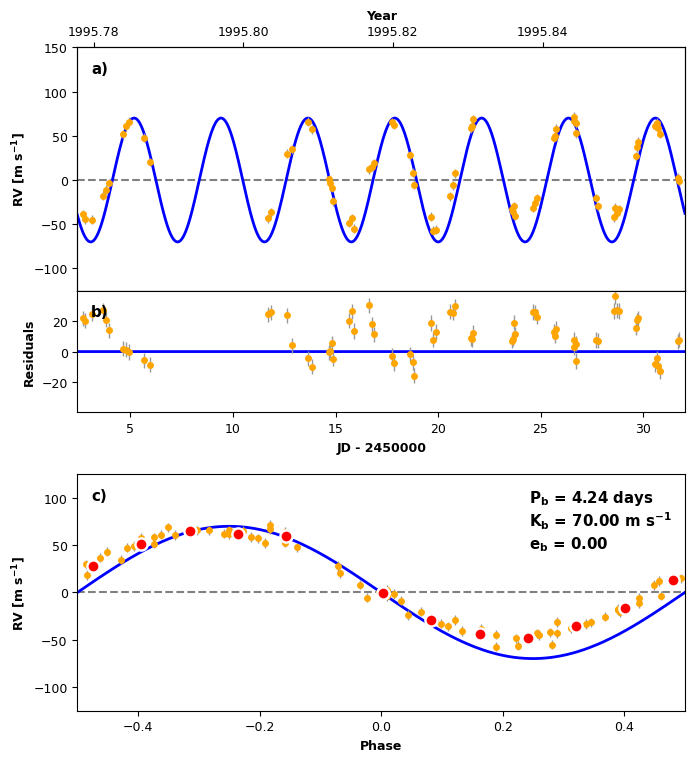

In [85]:
post = radvel.posterior.Posterior(like) # initialize radvel.Posterior object

RVPlot = orbit_plots.MultipanelPlot(post, legend = False)
RVPlot.plot_multipanel();

A quick note:
- Plot a) shows our data alongside our best-fit model.
- Plot b) shows the residuals -- or difference between our model and our data -- of each data point.
- Plot c) shows a phase-folded diagram, where the data has been layered over itself so it shows the radial velocity as a function of *phase of the orbit* instead of time. On plot c), the red dots correspond to binned data, the average of each data point around that phase.)

Our initial model isn't *terrible*, but it's clear it's not perfect. Let's take one last look at our parameters before we fit them.

In [86]:
print(like)

parameter                     value      vary
per1                        4.23717       True
tc1                               2       True
secosw1                       0.001       True
sesinw1                       0.001       True
k1                               70       True
dvdt                              0      False
curv                              0      False
gamma                             0       True
jit                               0       True
tp1                         1.47036           
e1                            2e-06           
w1                         0.785398           



Hey, it looks like there are two extra parameters that are being fit! `gamma` refers to the flat offset in radial velocity we can add, and `jit` refers to the extra white noise being added to each uncertainty value in case we're underestimating them. In general, it's a good idea to keep those on, though, so we'll do so here.

Now, we can just have code fit for these parameters! We can do a simple optimization fit, through something like scipy's `optimize.minimize()` routine, or we can do a more detailed MCMC fit. Let's do both, one after the other. First up is our simple optimization:

In [87]:
res = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )
print(post)

parameter                     value      vary
per1                        4.23389       True
tc1                         1.90129       True
secosw1                  -0.0380444       True
sesinw1                   0.0788951       True
k1                          57.9315       True
dvdt                              0      False
curv                              0      False
gamma                       9.86025       True
jit                         2.06929       True
tp1                         2.19959           
e1                       0.00767182           
w1                          2.02012           

Priors
------



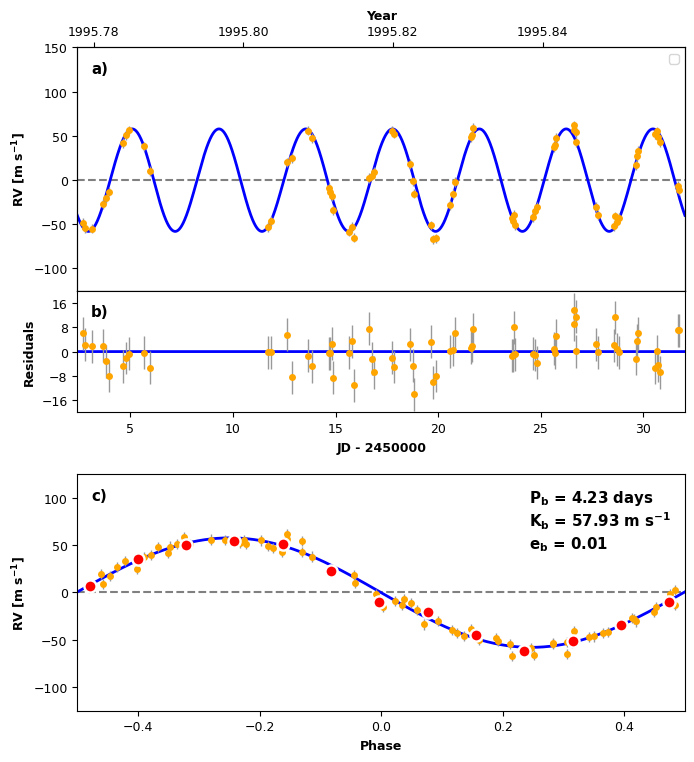

In [88]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel();

### Part 4: MCMC Fitting

And that fit looks a lot better! But what if we want to figure out a distribution of possible parameters? Sometimes we want to get uncertainties on, say, $K$, and to do that we need a full MCMC fit. Alternatively, there may be priors we want to incorporate, to prevent nonsense parameters (such as a negative jitter) or to inform our fits based on other data.

(For information on what an MCMC fit is or why it's useful, check out my other presentation about this topic!)

Let's add some priors here. The only priors I'm going to include here is a uniform prior on the jitter (called a HardBounds prior in ``radvel``), to ensure it's non-negative. If you want a list of other priors, though, feel free to look [here](https://radvel.readthedocs.io/en/latest/prior.html); the Gaussian prior (also called a Normal prior) and the Jeffreys prior (also called a reciprocal or log-uniform prior) are both very commonly used in radial velocity fits!

In [89]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.HardBounds('jit', 0., 100.)]

Now, we can run our MCMC fit! ``radvel`` has its own MCMC fitting code, separate from `emcee`, but in practice it works very similarly.

Note that MCMC fits are pretty computationally intensive. With this data, it takes a few minutes to run on my MacBook Air, but your speed may vary on different computers, or if we were using more data, or running a longer fit.

In [90]:
df = radvel.mcmc(post, nwalkers=32, nrun=5000)

64000/1280000 (5.0%) steps complete; Running 2836.85 steps/s; Mean acceptance rate = 47.1%; Min Auto Factor =  33; Max Auto Relative-Change =   inf; Min Tz = 3836.7; Max G-R = 1.007
Discarding burn-in now that the chains are marginally well-mixed

256000/1280000 (20.0%) steps complete; Running 2832.04 steps/s; Mean acceptance rate = 44.4%; Min Auto Factor =  63; Max Auto Relative-Change = 0.0225; Min Tz = 7953.9; Max G-R = 1.004
Chains are well-mixed after 256000 steps! MCMC completed in 1.5 minutes




Now, let us print our results! We can plot our best-fit model:

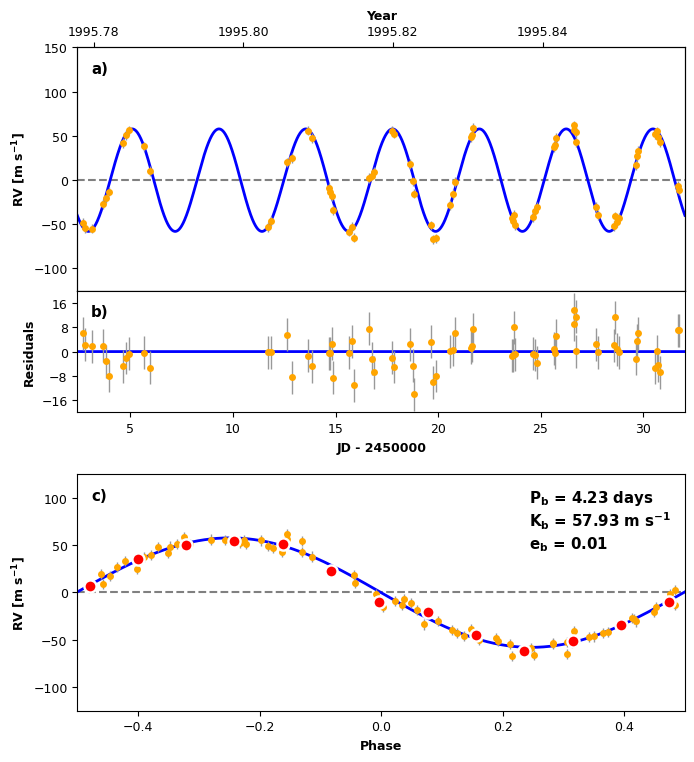

In [91]:
RVPlot = orbit_plots.MultipanelPlot(post, legend = False)
RVPlot.plot_multipanel();

That fit looks really good! And now we can create a *corner plot*, which shows not just the distribution of each variable but also a plot showing the correlation of each pair of variables as well.

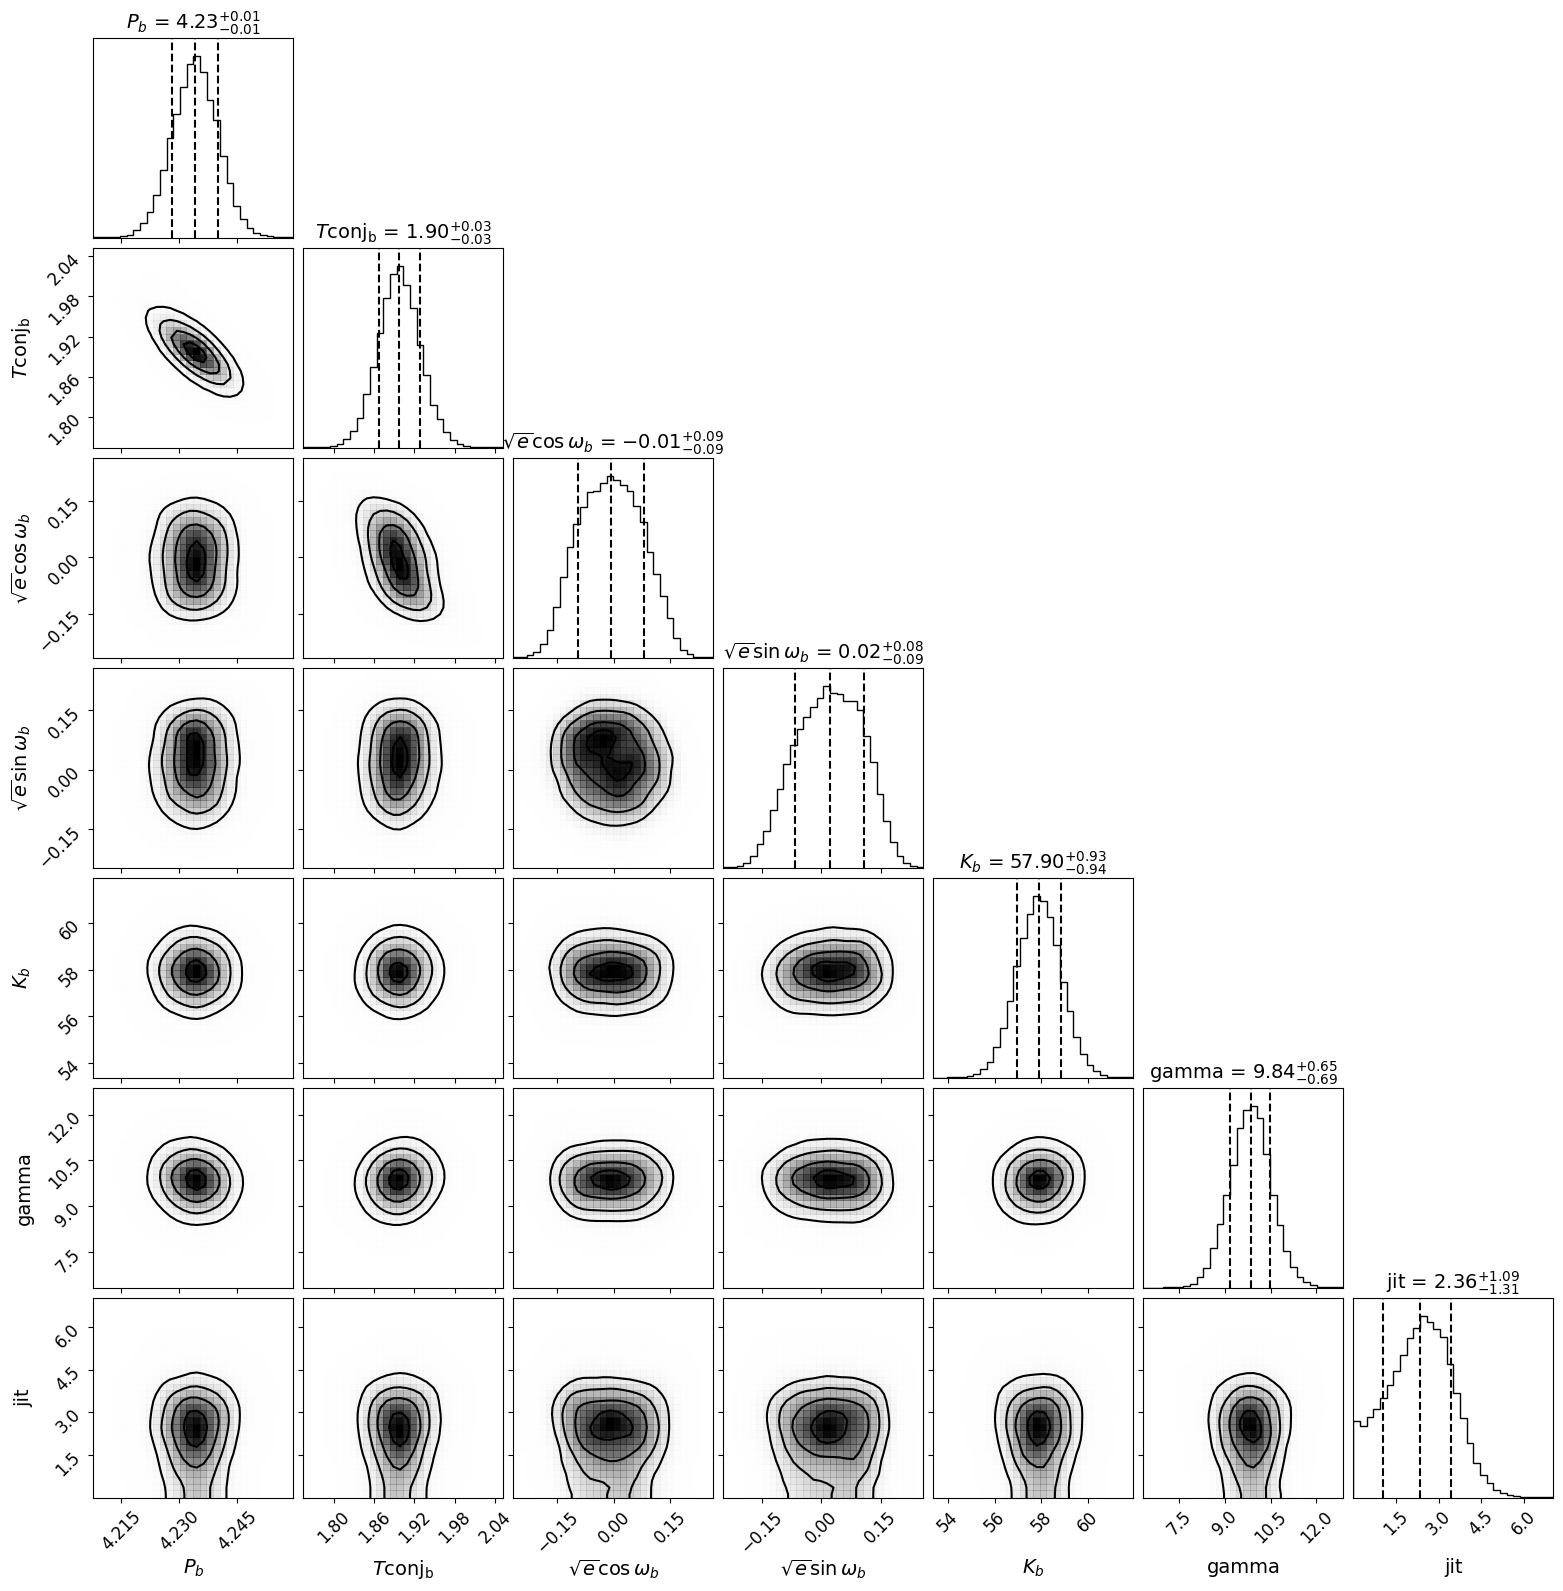

In [92]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

That corner plot looks totally normal! We do see some correlation between variables -- such as the anticorrelation between $P$ and $t_0$ -- but that's not a bad thing.

And we can compare to the values the original paper found. The original paper found $P = 4.2293 ± 0.0011$ days and $K = 59 ± 3$ m/s -- both of which are consistent with what we found! If you want to convert semi-amplitude to planetary mass, you can use this function:

In [93]:
def planetary_mass(K, P, M_star):
    '''
    Given a semi-amplitude (in m/s), a period (in days), and a stellar mass (in solar masses),
    returns the mass of the planet that caused that signal (in Earth masses).
    '''
    
    return (1. / 0.647204) * K * np.power(M_star, 2/3) * np.power(P, 1/3)

# 51 Pegasi has a mass of 1.12 solar masses

planetary_mass(57.92, 4.23, 1.12)

156.09158766998203

Looks like 51 Pegasi b is 156 Earth masses, or about half the mass of Jupiter. Note that this is a *minimum mass*, as we do not know the inclination of this planet, but it's all we've got!

This demo details the process of how to fit radial velocity data. For more practice with it on your own, feel free to try the Radial Velocities assignment!

In [94]:
print(data.columns)


Index(['Date (JD - 2450000)', 'RV (m/s)', 'RV Uncertainty (m/s)'], dtype='object')


In [95]:
import pandas as pd

# Veriyi yükleme
df = pd.read_csv("my_gaiaa.csv")

In [96]:
df.head()

,source_id,ra,dec,radial_velocity,radial_velocity_error,phot_g_mean_mag,parallax,pmra,pmdec,phot_variable_flag
0,6767389310419496576,297.490638,-24.863397,42.360035,2.603151,12.674158,NaN,NaN,NaN,NOT_AVAILABLE
1,6767377318870799872,297.472744,-24.907077,-1.116100,1.809389,12.516285,5.493466,-5.836990,14.354876,NOT_AVAILABLE
2,6767383361884566400,297.253482,-24.949324,35.900381,0.480566,11.686354,1.298843,-1.839975,-2.982950,NOT_AVAILABLE
3,6767384087739301632,297.334436,-24.889811,-85.706527,0.565034,11.074074,0.199509,3.834648,-4.429694,NOT_AVAILABLE
4,6767384770633798784,297.198392,-24.967267,-8.820053,1.550667,11.635368,0.659157,2.007097,-2.966362,NOT_AVAILABLE


In [97]:
df.shape

(49, 10)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   source_id              49 non-null     int64  
 1   ra                     49 non-null     float64
 2   dec                    49 non-null     float64
 3   radial_velocity        49 non-null     float64
 4   radial_velocity_error  49 non-null     float64
 5   phot_g_mean_mag        49 non-null     float64
 6   parallax               48 non-null     float64
 7   pmra                   48 non-null     float64
 8   pmdec                  48 non-null     float64
 9   phot_variable_flag     49 non-null     object 
dtypes: float64(8), int64(1), object(1)
memory usage: 4.0+ KB


In [99]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
source_id,49.0,6.767424e+18,3.254861e+13,6.767371e+18,6.767387e+18,6.767437e+18,6.767449e+18,6.767472e+18
ra,49.0,2.972404e+02,1.289587e-01,2.970162e+02,2.971598e+02,2.972272e+02,2.973342e+02,2.974906e+02
dec,49.0,-2.473629e+01,1.637670e-01,-2.497586e+01,-2.489217e+01,-2.475954e+01,-2.456518e+01,-2.450415e+01
radial_velocity,49.0,-1.503966e+01,4.209522e+01,-9.446471e+01,-3.645795e+01,-2.310382e+01,1.170481e+01,8.825959e+01
radial_velocity_error,49.0,1.633258e+00,1.567262e+00,2.597838e-01,7.120077e-01,1.190214e+00,1.986155e+00,8.862132e+00
phot_g_mean_mag,49.0,1.234550e+01,6.425857e-01,1.043105e+01,1.196347e+01,1.242540e+01,1.289276e+01,1.335955e+01
parallax,48.0,1.520511e+00,1.750096e+00,1.109493e-01,4.140761e-01,8.541323e-01,1.608413e+00,7.401922e+00
pmra,48.0,8.636274e-01,1.282592e+01,-4.401136e+01,-5.004541e+00,2.117342e-01,3.589694e+00,4.284670e+01
pmdec,48.0,-6.893984e+00,1.093229e+01,-4.929121e+01,-9.049250e+00,-3.995685e+00,-1.103227e+00,1.435488e+01


In [100]:
# Eksik değerleri içeren satırları düşürme
df = df.dropna()

# Temizlenmiş veriyi gözlemleyin
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 1 to 48
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   source_id              48 non-null     int64  
 1   ra                     48 non-null     float64
 2   dec                    48 non-null     float64
 3   radial_velocity        48 non-null     float64
 4   radial_velocity_error  48 non-null     float64
 5   phot_g_mean_mag        48 non-null     float64
 6   parallax               48 non-null     float64
 7   pmra                   48 non-null     float64
 8   pmdec                  48 non-null     float64
 9   phot_variable_flag     48 non-null     object 
dtypes: float64(8), int64(1), object(1)
memory usage: 4.1+ KB
None
             source_id          ra        dec  radial_velocity  \
1  6767377318870799872  297.472744 -24.907077        -1.116100   
2  6767383361884566400  297.253482 -24.949324        35.900381   
3  6767384087

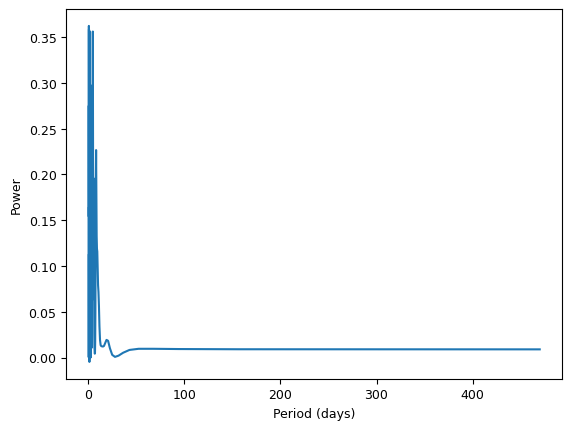

In [107]:
from astropy.timeseries import LombScargle
import numpy as np
import matplotlib.pyplot as plt

# Zaman serisi için örnek veriler
# Burada Date sütununu temsil eden veri yok, bu nedenle örnek bir zaman serisi oluşturmalıyız.
# Gerçek zaman veriniz varsa, bu kısımda o verileri kullanmalısınız.
# Burada sadece radial_velocity ve hata değeri var.
time = np.arange(len(df))  # Örnek bir zaman serisi
velocity = df['radial_velocity']
uncertainty = df['radial_velocity_error']

# Lomb-Scargle dönüştürmesi
frequency, power = LombScargle(time, velocity, uncertainty).autopower()

# Sonucu görselleştirme
plt.plot(1/frequency, power)
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()


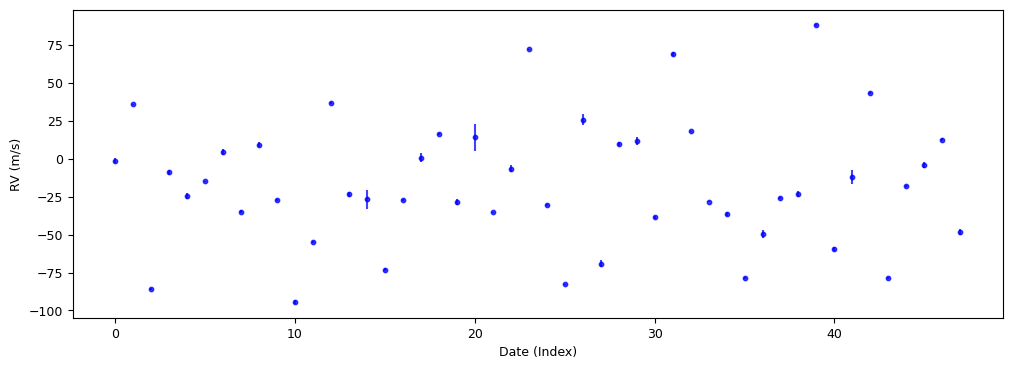

In [109]:
import matplotlib.pyplot as plt

# Örnek veri
# df = pd.read_csv("my_gaiaa.csv")  # Zaten df olarak yükledik

# Date sütunu olmadığından, burada bir zamana bağlı olarak x ekseni oluşturuyoruz
df['Date'] = range(len(df))  # Zaman sütunu olarak satır indekslerini kullanıyoruz

# Grafik oluşturma
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(df['Date'], df['radial_velocity'], s=10, color='blue', alpha=0.75)
ax.errorbar(x=df['Date'], y=df['radial_velocity'], yerr=df['radial_velocity_error'], color='blue', alpha=0.75, ls='None')
ax.set_xlabel("Date (Index)")
ax.set_ylabel("RV (m/s)")
plt.show()


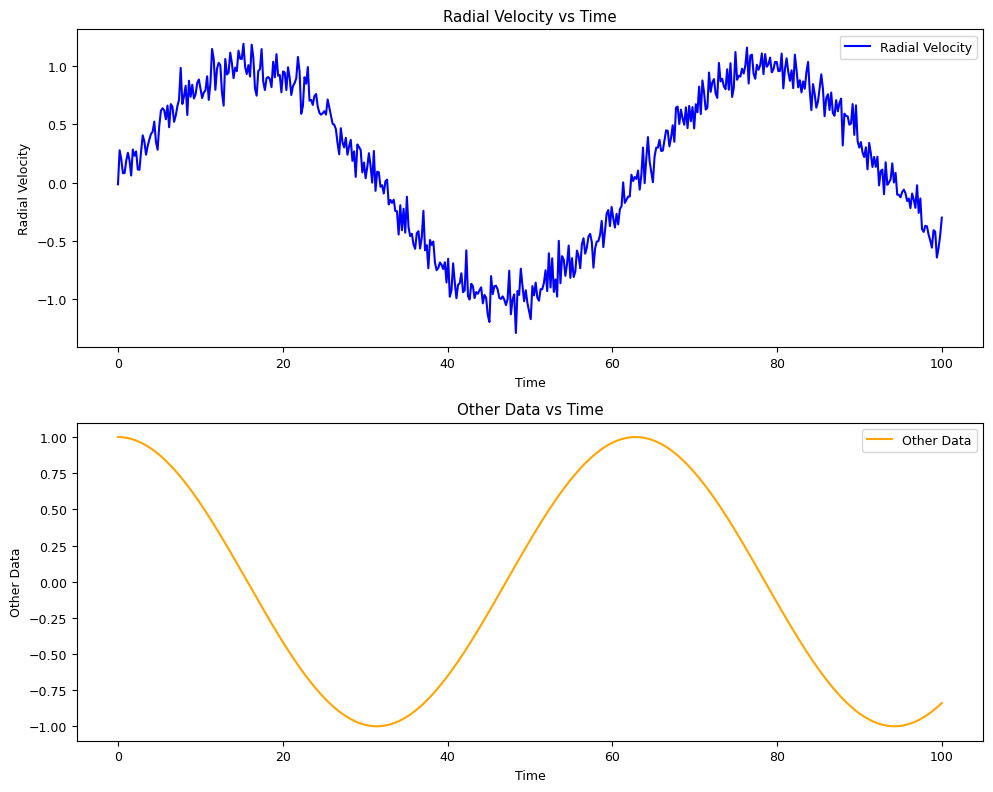

In [110]:
# Örnek veriler oluşturma
time = np.linspace(0, 100, 500)  # Zaman dizisi
rv_data = np.sin(time / 10) + np.random.normal(scale=0.1, size=time.shape)  # Radial velocity (RV) verisi
other_data = np.cos(time / 10)  # Diğer bir örnek veri

# Çoklu panel grafiği
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 satır, 1 sütun

# Birinci panel için RV verisi
axs[0].plot(time, rv_data, label='Radial Velocity', color='blue')
axs[0].set_title('Radial Velocity vs Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Radial Velocity')
axs[0].legend()

# İkinci panel için diğer veri
axs[1].plot(time, other_data, label='Other Data', color='orange')
axs[1].set_title('Other Data vs Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Other Data')
axs[1].legend()

plt.tight_layout()
plt.show()  # Grafiği göster

In [ ]:
#pip install astroquery